## Self-Organizing Map

In [3]:
import time
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

%matplotlib inline
%load_ext cython

cpu


### Implementation

In [4]:
%%cython

import numpy as np
cimport numpy as npc
from cython.parallel import parallel, prange

cpdef npc.ndarray euclidian(npc.ndarray a, npc.ndarray b, int axis=-1):
    return np.sqrt(np.sum(np.square(a - b), axis=axis))

cpdef calculate_theta(dst, dem):
     return np.mean(np.exp(-((np.square(dst))/dem)))

cpdef npc.ndarray find_neighbourhood(BMU, npc.ndarray lattice, int radius=5):
    ngb = euclidian(BMU, lattice, axis=-1)
    return lattice[np.where((ngb > 0) & (ngb <= radius))]

cpdef npc.ndarray run_som(npc.ndarray X, npc.ndarray W, npc.ndarray lattice, int radius, float lr, float sigma, int size):
    cdef float dem = (2*(np.square(sigma)))
    for xi in X:
        # Find the BMU of the point
        dist = euclidian(xi, W, axis=-1)
        BMU = np.asarray(np.where(dist==np.min(dist))).ravel()[:2]
        # If found a BMU
        if BMU is not None:
            # Find Neighbourhood of BMU using lattice matrix
            ngb = find_neighbourhood(BMU, lattice, radius)
            # Neighbourhood update
            BMU_node = W[tuple(BMU)]
            for ng in ngb:
                indx = tuple(np.split(ng, 2))
                ngb_node = W[indx]
                dst_n = euclidian(BMU_node, ngb_node, axis=-1)
                theta = calculate_theta(dst_n, dem)
                W[indx] += theta * (lr * (xi - ngb_node))
            # BMU update
            W[tuple(BMU)] += (lr * (xi - BMU_node))
    return W

In [5]:
def calculate_and_adjust_neighbourhood(xi, W, BMU_node, lr, dem, ng):
    indx = tuple(np.split(ng, 2))
    ngb_node = W[indx]
    dst_n = euclidian(BMU_node, ngb_node, axis=-1)
    theta = calculate_theta(dst_n, dem)
    return indx, W[indx] + (theta * (lr * (xi - ngb_node)))


class SOM:
    
    def __init__(self, units=10, lr=1e-1, radius=5, verbose=False):
        self._units = units
        self._lr = lr
        self._sig = 1
        self._radius = radius
        self.W = np.ones((self._units, self._units, 1)).ravel()
        self.verbose = verbose
    
    def train(self, x, epochs=250, sample_rate=10):
        qtd, self._size = x.shape
        # Define the Units Weights
        mn, mx = np.min(x), np.max(x)
        # mm = (np.abs(mn) + np.abs(mx)) / 2
        # mn = mn + (mm / 2) if mn < 0 else mn - (mm / 2)
        # mx = mx + (mm / 2) if mx < 0 else mx - (mm / 2)
        # Create the units (neurons) in the space as a 2D grid
        space = np.linspace(mn, mx, self._units)
        self.W = np.ones((self._units, self._units, self._size)).ravel()
        self.W = self.W.reshape(self._units, self._units, self._size)
        for m in range(self._units):
            for j in range(self._size):
                if j == 0:
                    self.W[:, m, j] = self.W[:, m, j] * space
                elif j == self._size-1:
                    self.W[:, m, j] = self.W[:, m, j] * space[m]
                else:
                    self.W[:, m, j] = self.W[:, m, j] * np.random.uniform(1e-3, 1)
                #else:
                    #self.W[:, m, j] = self.W[:, m, j] * space[j]
        # Create a lattice matrix to find the Neighbourhood of a BMU
        idx = np.indices(self.W.shape[:2])
        idx = np.vstack([ix.flatten() for ix in idx])
        self._lattice = np.stack([ix for ix in idx], axis=1)
        # Running epochs!
        start = time.time()
        with ProcessPoolExecutor(max_workers=4) as exc:
            for epoch in range(epochs):
                samples = x[np.random.choice(x.shape[0], sample_rate, replace=False)]
                # self.W = run_som(samples, self.W, self._lattice, self._radius, self._lr, self._sig, self._size)
                for xi in samples:
                    # Find the BMU of the point
                    dist = euclidian(xi, self.W, axis=-1)
                    BMU = np.asarray(np.where(dist==np.min(dist))).ravel()[:2]
                    # If found a BMU
                    if BMU is not None:
                        # Find Neighbourhood of BMU using lattice matrix
                        ngb = find_neighbourhood(BMU, self._lattice, self._radius)
                        # Neighbourhood update
                        BMU_node = self.W[tuple(BMU)]
                        dem = (2*(np.square(self._sig)))
                        # Multiprocess module
                        fn = partial(calculate_and_adjust_neighbourhood, xi, self.W, BMU_node, self._lr, dem)
                        results = list(exc.map(fn, ngb, chunksize=10))
                        for result in results:
                            self.W[result[0]] = result[1]
                        # BMU update
                        self.W[tuple(BMU)] += (self._lr * (xi - BMU_node))
                if epoch % 25 == 0 and epoch > 0:
                    decay = np.exp(-epoch/epochs)
                    # Learning rate decay
                    self._lr *= decay
                    self._sig = self._radius * decay
                    if self._radius > 1:
                        self._radius = np.ceil(self._radius * decay)
        if self.verbose:
            print(f"Running time: {time.time() - start}")
    
    def predict(self, x):
        pass

### Toy datasets provided by scikit-learn

Running time: 6.673513889312744


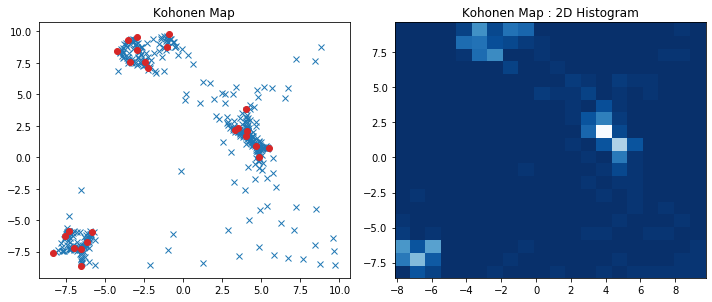

In [5]:
x, y = make_blobs(25, n_features=2, centers=3, random_state=42)

som = SOM(units=20, verbose=True)
som.train(x)
W = som.W
W = W.flatten().reshape(-1, 2)

fig = plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Kohonen Map")
plt.plot(W[:, 0], W[:, 1], 'x', c='C0')
plt.plot(x[:, 0], x[:, 1], 'o', c='C3')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [6]:
X, y = make_moons(500, noise=0.075)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20)
som.train(X_train)
W = som.W.flatten().reshape(-1, 2)

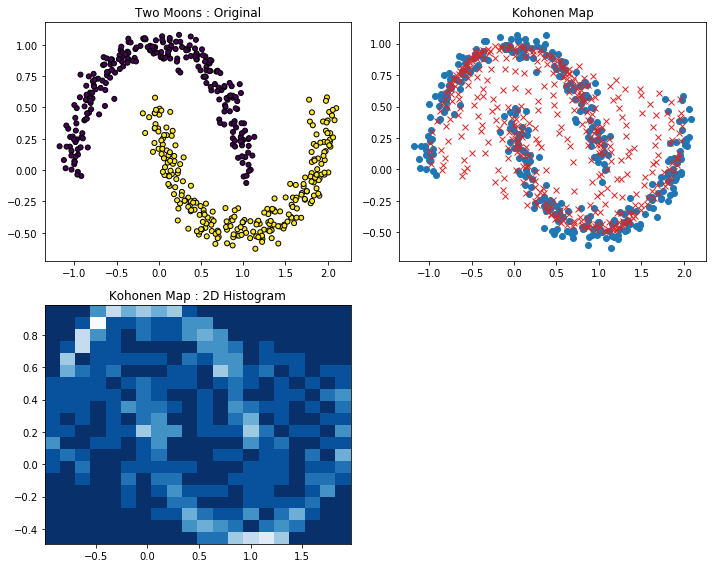

In [7]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [8]:
X, y = make_classification(n_samples=500, n_features=2, n_classes=3, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20)
som.train(X_train)
W = som.W.flatten().reshape(-1, 2)

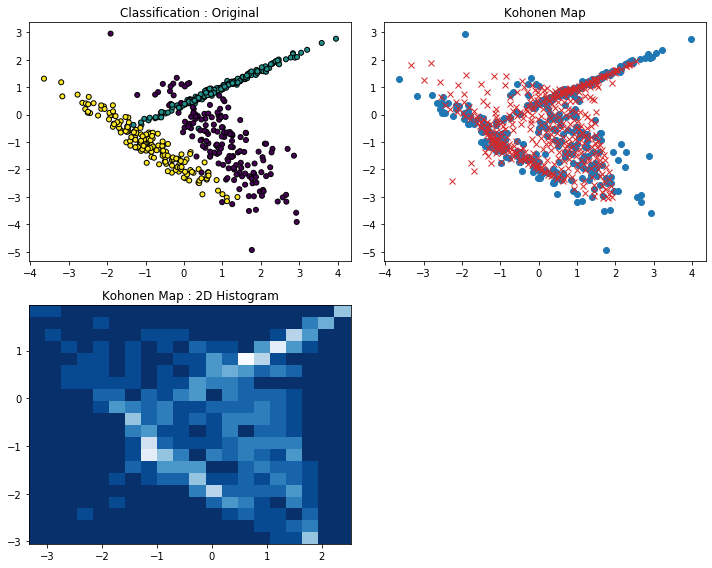

In [9]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Classification : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [10]:
X, y = make_classification(n_samples=500, n_features=3, n_classes=3, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20)
som.train(X_train, epochs=500, sample_rate=20)
W = som.W.flatten().reshape(-1, 3)

<IPython.core.display.Javascript object>


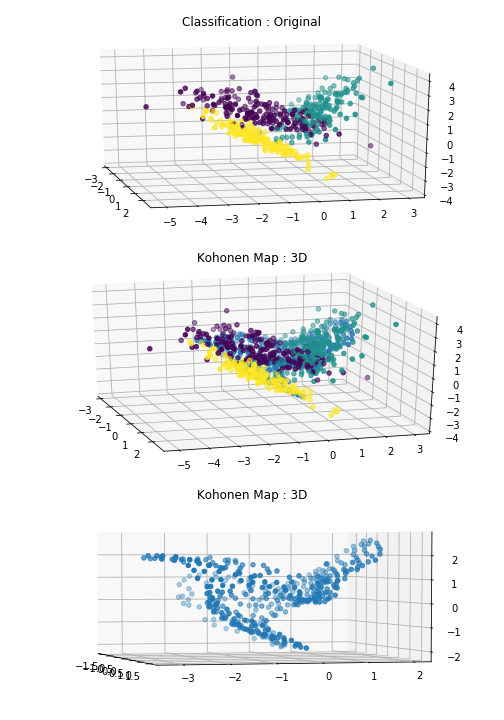

In [12]:
%matplotlib notebook
plt.figure(figsize=(7, 10))
ax = plt.subplot(3, 1, 1, projection='3d')
plt.title("Classification : Original")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax = plt.subplot(3, 1, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(3, 1, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [13]:
%matplotlib inline

In [14]:
X, y = make_circles(500, noise=0.05, factor=.33)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20)
som.train(X_train, epochs=400, sample_rate=20)
W = som.W.flatten().reshape(-1, 2)

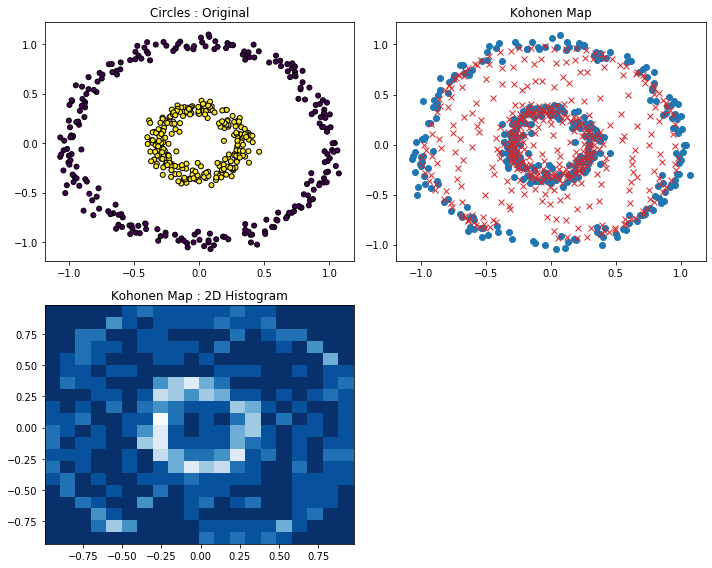

In [15]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Circles : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [16]:
X, y = make_blobs(500, n_features=2, centers=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20)
som.train(X_train, epochs=300)
W = som.W.flatten().reshape(-1, 2)

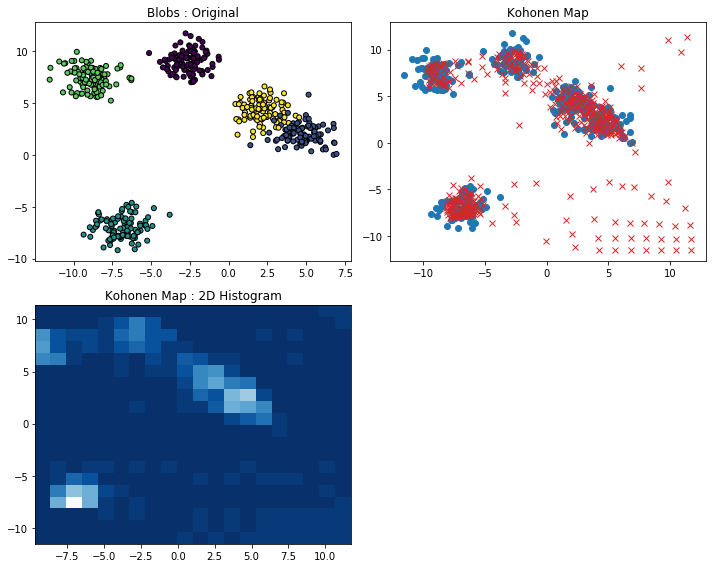

In [17]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Blobs : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [18]:
X, y = make_blobs(500, n_features=3, centers=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20)
som.train(X_train, epochs=500, sample_rate=20)
W = som.W.flatten().reshape(-1, 3)

<IPython.core.display.Javascript object>


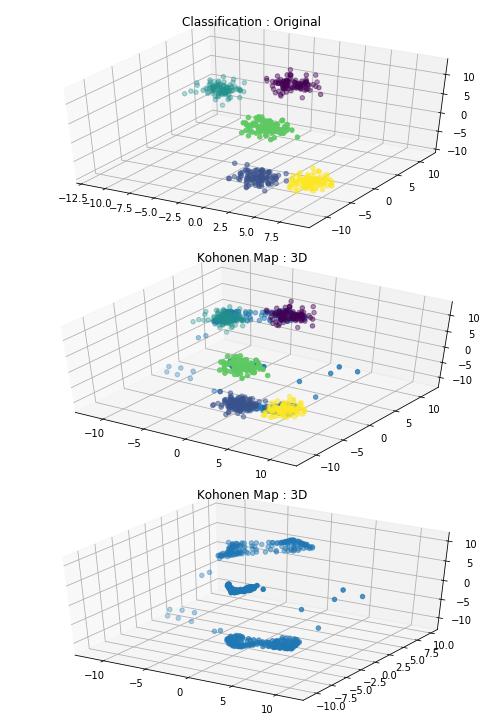

In [19]:
%matplotlib notebook

plt.figure(figsize=(7, 10))
ax = plt.subplot(3, 1, 1, projection='3d')
plt.title("Classification : Original")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax = plt.subplot(3, 1, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(3, 1, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [20]:
%matplotlib inline

## Self-organizing map on MNIST

#### Applying PCA and T-SNE to MNIST and after that SOM

Loading MNIST from scikit-learn to test out against the self-Organizing Map.

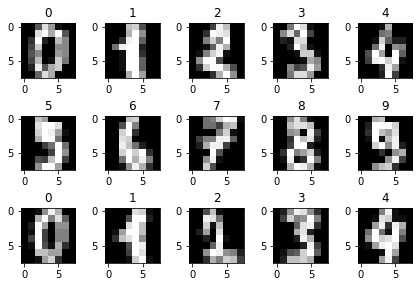

In [21]:
digits = load_digits(n_class=10)
x = digits.data
y = digits.target

for i in range(15):
    img, title = x[i], y[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title.item())
    plt.imshow(img.reshape(8, 8), cmap="gray")
plt.tight_layout()
plt.show()

In [22]:
x_pca = TruncatedSVD(n_components=2, random_state=42).fit_transform(x)
x_pca = StandardScaler().fit_transform(x_pca)

som = SOM(units=20, radius=20)
som.train(x_pca, epochs=500, sample_rate=20)
W = som.W.flatten().reshape(-1, 2)

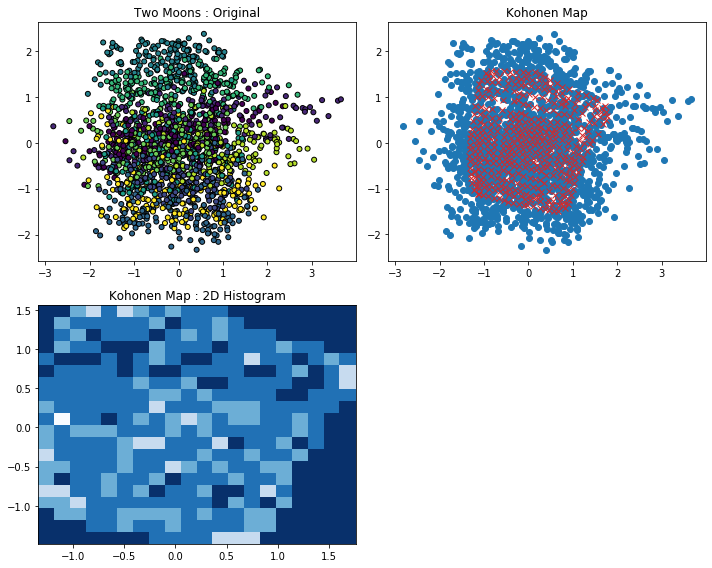

In [23]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [24]:
x_pca = TruncatedSVD(n_components=3, random_state=42).fit_transform(x)
x_pca = StandardScaler().fit_transform(x_pca)

som = SOM(units=20)
som.train(x_pca, epochs=500, sample_rate=25)
W = som.W.flatten().reshape(-1, 3)

<IPython.core.display.Javascript object>


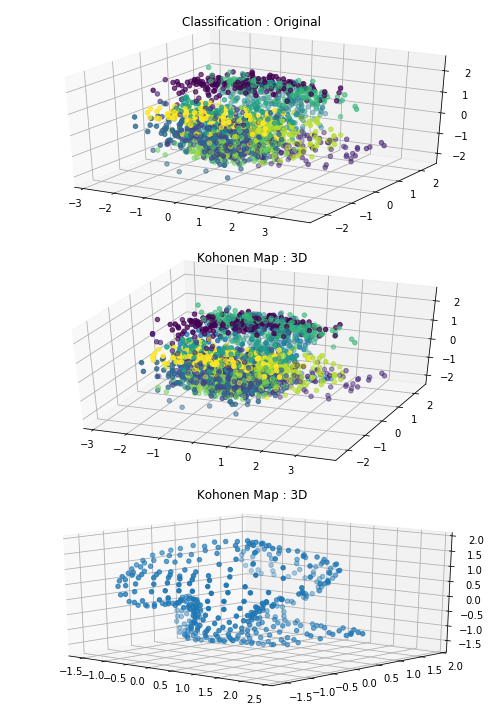

In [25]:
%matplotlib notebook

plt.figure(figsize=(7, 10))
ax = plt.subplot(3, 1, 1, projection='3d')
plt.title("Classification : Original")
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=y)
ax = plt.subplot(3, 1, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=y)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(3, 1, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [26]:
%matplotlib inline

In [27]:
x_tsne = TSNE(n_components=2, init='pca', random_state=0).fit_transform(x)
x_tsne = StandardScaler().fit_transform(x_tsne)

som = SOM(units=20, radius=10)
som.train(x_tsne, epochs=500, sample_rate=15)
W = som.W.flatten().reshape(-1, 2)

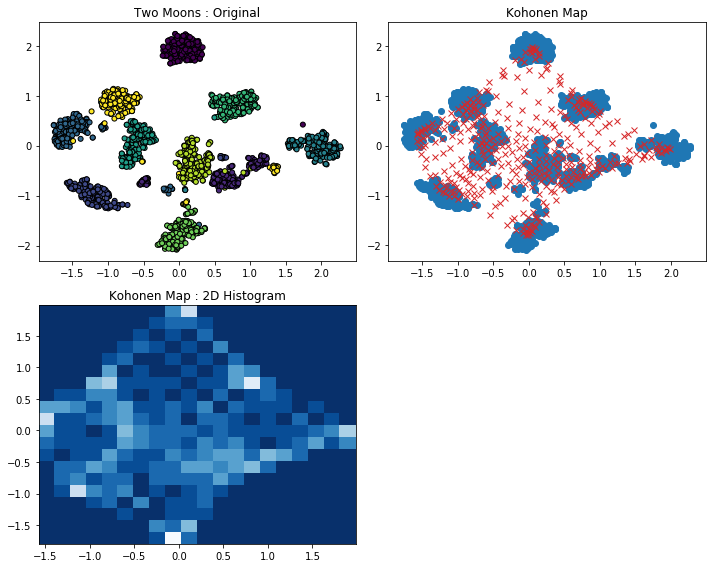

In [28]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [33]:
x_tsne = TSNE(n_components=3, init='pca', random_state=0).fit_transform(x)
x_tsne = StandardScaler().fit_transform(x_tsne)

som = SOM(units=25, radius=15)
som.train(x_tsne, epochs=500, sample_rate=30)
W = som.W.flatten().reshape(-1, 3)

<IPython.core.display.Javascript object>


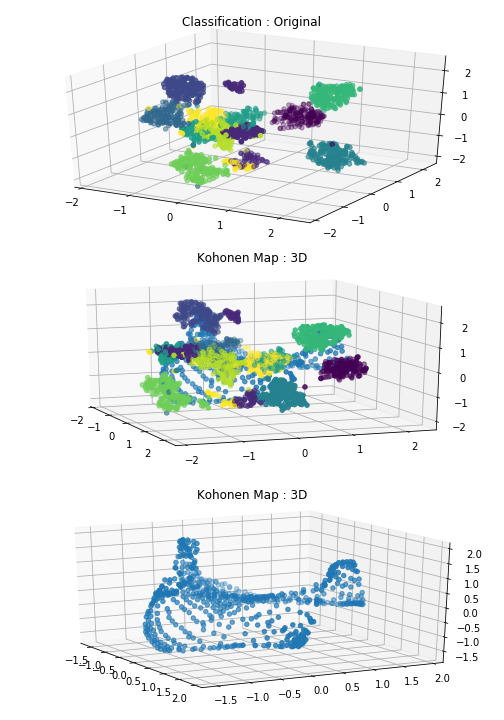

In [34]:
%matplotlib notebook

plt.figure(figsize=(7, 10))
ax = plt.subplot(3, 1, 1, projection='3d')
plt.title("Classification : Original")
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=y)
ax = plt.subplot(3, 1, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=y)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(3, 1, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [35]:
%matplotlib inline

#### Autoencoder

Taken from : [Building Autoencoder in Pytorch](https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c)

The problem with the above techniques is that it works fine with a low dimensional image, like the toy MNIST provided by scikit-learn.

If one try with the MNIST dataset provided by pytorch, well... it a little differente history.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=True, num_workers=2)

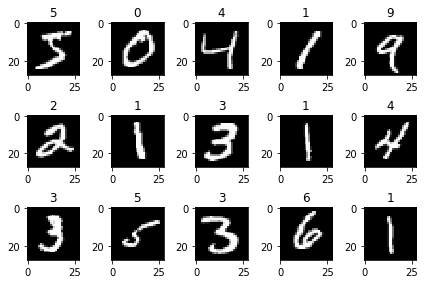

In [7]:
for i in range(15):
    img, title = mnist_trainset.data[i], mnist_trainset.targets[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title.item())
    plt.imshow(img.numpy(), cmap="gray")
plt.tight_layout()
plt.show()

In [8]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

    
class UnFlatten(nn.Module):
    def forward(self, input, size=8):
        return input.view(input.size(0), size, 2, 2)

    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
            Flatten(),
            nn.Linear(32, 10)
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            UnFlatten(),
            nn.ConvTranspose2d(8, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

In [9]:
num_epochs = 2

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in trainloader:
        inputs, labels = data
        # ===================forward=====================
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), inputs.to(device))
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss))

epoch [1/2], loss:0.0360
epoch [2/2], loss:0.0330


In [22]:
outputs = []
labels = []
for data in testloader:
    inputs, lbs = data
    outs = model.encode(inputs.to(device)).cpu().data.numpy()
    outputs+= list(outs)
    labels += list(lbs.numpy().ravel())
outputs = np.asarray(outputs)
labels = np.asarray(labels)

In [26]:
x_tsne = TSNE(n_components=3, init='pca', random_state=0).fit_transform(outputs)
x_tsne = StandardScaler().fit_transform(x_tsne)

som = SOM(units=25, radius=15)
som.train(x_tsne, epochs=500, sample_rate=30)
W = som.W.flatten().reshape(-1, 3)

<IPython.core.display.Javascript object>


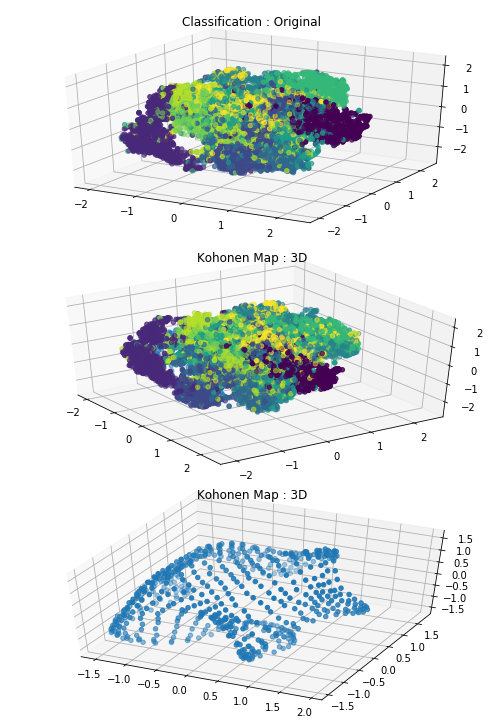

In [30]:
%matplotlib notebook

plt.figure(figsize=(7, 10))
ax = plt.subplot(3, 1, 1, projection='3d')
plt.title("Classification : Original")
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=labels)
ax = plt.subplot(3, 1, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=labels)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(3, 1, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline